In [796]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [777]:
data = pd.read_csv("train.csv").drop(columns="Name")

data.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False


In [987]:
def preprocess(data):
    df = data.copy()
    group = df["PassengerId"].str.split("_", expand=True)[0].str.lstrip("0")
    position = df["PassengerId"].str.split("_", expand=True)[1].str.lstrip("0")
    
    df["Group"] = group
    df["Position"] = position
    df.drop(columns="PassengerId", inplace=True)


    deck = df["Cabin"].str.split("/", expand=True)[0]
    num = df["Cabin"].str.split("/", expand=True)[1]
    side = df["Cabin"].str.split("/", expand=True)[2]

    df["Deck"] = deck
    df["Num"] = num.astype(float)
    df["Side"] = side
    df.drop(columns="Cabin", inplace=True)

    df["VIP"].replace({True: "Yes", False: "No"}, inplace=True)
    df["CryoSleep"].replace({True: "Yes", False: "No"}, inplace=True)
    
    if "Transported" in df.columns:
        df = df[["Group", "Position", "Deck", "Num", "Side", "CryoSleep", "VIP", "Age", "RoomService", "FoodCourt", "ShoppingMall",
                "Spa", "VRDeck", "HomePlanet", "Destination", "Transported"]]
    else:
        df = df[["Group", "Position", "Deck", "Num", "Side", "CryoSleep", "VIP", "Age", "RoomService", "FoodCourt", "ShoppingMall",
                "Spa", "VRDeck", "HomePlanet", "Destination"]]      


    return df

def handle_na(data):
    df = data.copy()
    df.dropna(thresh=10, inplace=True)

    df.fillna(value={
        "Age": df.Age.mean(),
        "VIP": "No",
        "RoomService": df.RoomService.mean(),
        "FoodCourt": df.FoodCourt.mean(),
        "ShoppingMall": df.ShoppingMall.mean(),
        "Spa": df.Spa.mean(),
        "VRDeck": df.VRDeck.mean(),
        "Destination": "Unknown",
        "HomePlanet": "Unknown",
        "CryoSleep": "Unknown",
        "Side": "Unknown",
        "Deck": "Unknown",
        "Cabin": "Unknown"
    }, inplace=True)

    return df

def encode(data):
    dummy_columns = ["Position", "Deck", "Side", "CryoSleep", "VIP", "HomePlanet", "Destination"]
    df = data.copy()
    df = pd.get_dummies(df, prefix=dummy_columns, columns=dummy_columns)

    return df

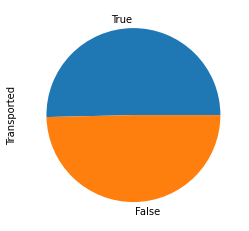

In [779]:
data.Transported.value_counts().plot.pie()
plt.show()

In [780]:
df_processed = handle_na(preprocess(data))
df_processed.head(3)

,Group,Position,Deck,Num,Side,CryoSleep,VIP,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet,Destination,Transported
0,1,1,B,0.0,P,No,No,39.0,0.0,0.0,0.0,0.0,0.0,Europa,TRAPPIST-1e,False
1,2,1,F,0.0,S,No,No,24.0,109.0,9.0,25.0,549.0,44.0,Earth,TRAPPIST-1e,True
2,3,1,A,0.0,S,No,Yes,58.0,43.0,3576.0,0.0,6715.0,49.0,Europa,TRAPPIST-1e,False


In [781]:
corr_tab = df_processed.corr(method="kendall").style.background_gradient(cmap="coolwarm", axis=None)
corr_tab.set_caption("Correlation Matrix(Kendall Tau)")

,Num,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
Num,1.000000,-0.104808,0.043763,-0.107045,0.052248,-0.073771,-0.080635,-0.037676
Age,-0.104808,1.000000,0.085434,0.153497,0.072563,0.141301,0.128736,-0.057486
RoomService,0.043763,0.085434,1.000000,0.135471,0.340718,0.188687,0.131983,-0.332711
FoodCourt,-0.107045,0.153497,0.135471,1.000000,0.135352,0.380202,0.398995,-0.160403
ShoppingMall,0.052248,0.072563,0.340718,0.135352,1.000000,0.188820,0.146434,-0.196768
Spa,-0.073771,0.141301,0.188687,0.380202,0.188820,1.000000,0.341898,-0.329442
VRDeck,-0.080635,0.128736,0.131983,0.398995,0.146434,0.341898,1.000000,-0.310983
Transported,-0.037676,-0.057486,-0.332711,-0.160403,-0.196768,-0.329442,-0.310983,1.000000


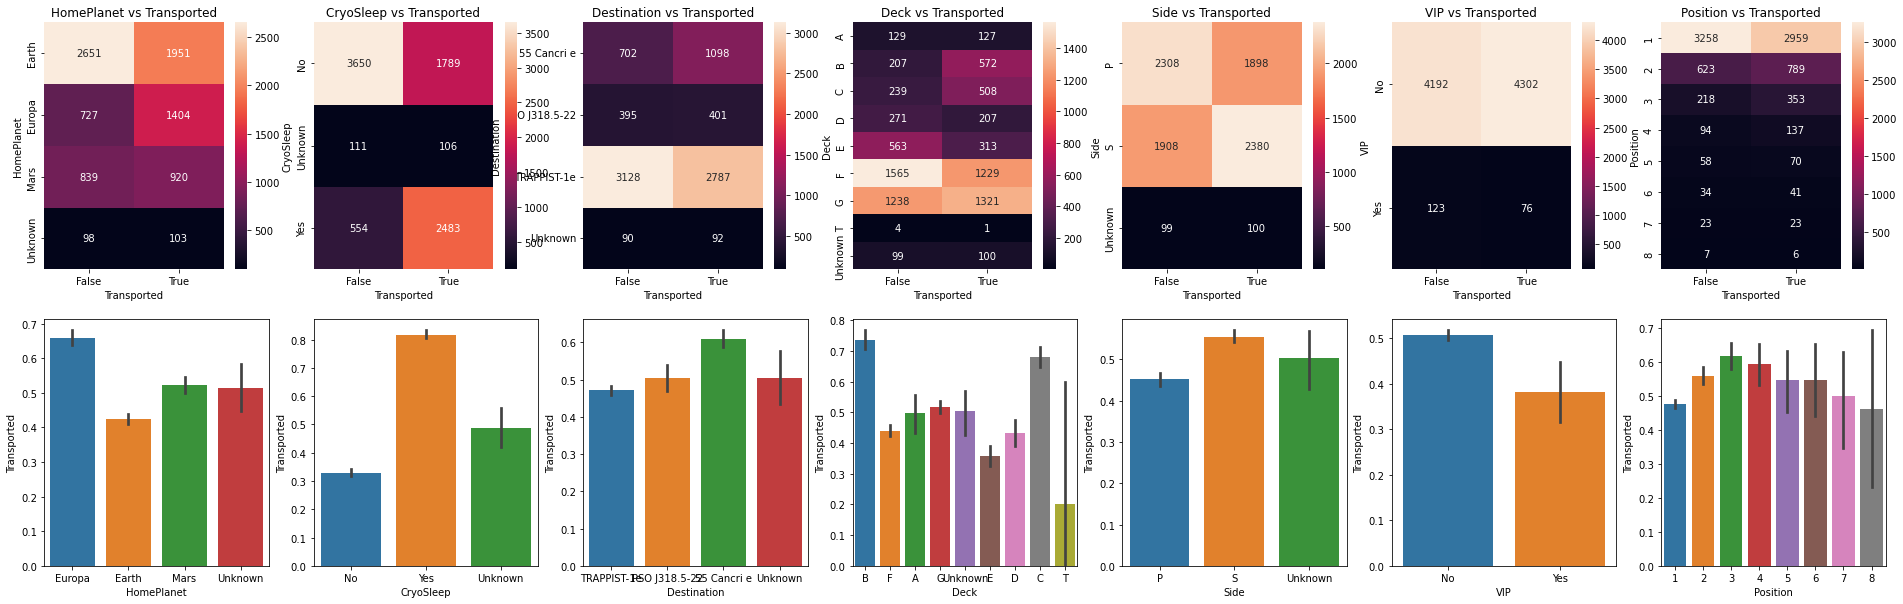

,Chi Score,P Values,Degree of Freedom,Expected
HomePlanet,324.967237,3.921492e-70,3,"[[2284.3241688715057, 2317.6758311284943], [10..."
CryoSleep,1861.749116,0.000000e+00,2,"[[2699.7912113194525, 2739.2087886805475], [10..."
Destination,106.394882,6.547434e-23,3,"[[893.4775106407454, 906.5224893592546], [395...."
Deck,392.288750,8.352488e-80,8,"[[127.07235706890602, 128.92764293109397], [38..."
Side,91.475193,1.369034e-20,2,"[[2087.7591165305416, 2118.2408834694584], [21..."
VIP,11.575952,6.681024e-04,1,"[[4216.221097434717, 4277.778902565283], [98.7..."
Position,75.220318,1.293731e-13,7,"[[3085.9720464741745, 3131.0279535258255], [70..."


In [782]:
df_processed = handle_na(preprocess(data))

fig, axs = plt.subplots(2, 7)
fig.set_size_inches(33, 10)


feature_list = ["HomePlanet", "CryoSleep", "Destination", "Deck", "Side", "VIP", "Position"]
chi2s = []
ps = []
dofs = []
expecteds = []

for index, column_name in enumerate(feature_list):
    sns.heatmap(pd.crosstab(df_processed[column_name], df_processed["Transported"]), annot=True, fmt='g', ax=axs[0][index]).title.set_text(f"{column_name} vs Transported")
    sns.barplot(x=column_name, y="Transported", data=df_processed, ax=axs[1][index])

    chi2, p, dof, expected = chi2_contingency(pd.crosstab(df_processed[column_name], df_processed["Transported"]))
    chi2s.append(chi2)
    ps.append(p)
    dofs.append(dof)
    expecteds.append(expected)

chi_scores = pd.DataFrame({
    "Chi Score": chi2s,
    "P Values": ps,
    "Degree of Freedom": dofs,
    "Expected": expecteds
}, index=feature_list)

plt.show()
chi_scores

In [783]:
unwanted_columns = ["Age", "Num"]
def drop_unwanted(data):
    df = data.copy()
    df.drop(columns=unwanted_columns, inplace=True)
    return df

df_processed = drop_unwanted(df_processed)

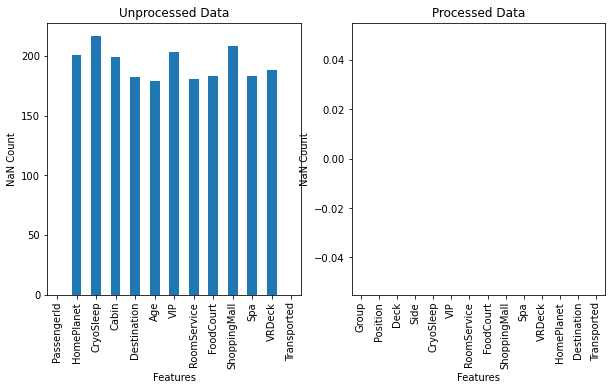

In [1110]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

axs[0].set_title("Unprocessed Data")
axs[0].set_xlabel("Features")
axs[0].set_ylabel("NaN Count")

axs[1].set_title("Processed Data")
axs[1].set_xlabel("Features")
axs[1].set_ylabel("NaN Count")

data.isna().sum().plot.bar(ax=axs[0])
df_processed.isna().sum().plot.bar(ax=axs[1])

plt.show()

In [816]:
x = encode(df_processed.drop(columns="Transported")).values
y = df_processed["Transported"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=40)

scaler = StandardScaler().fit(x_train)
x_train_scaled, x_test_scaled = scaler.transform(x_train), scaler.transform(x_test)

In [1027]:
from sklearn.neighbors import KNeighborsClassifier

parameters = {
    "n_neighbors": list(range(1, 20)),
    "metric": ["minkowski"],
    "p": [1, 2, 3, 4]
}

model_knn = GridSearchCV(KNeighborsClassifier(), parameters, n_jobs=-1)
model_knn.fit(x_train_scaled, y_train)

y_pred_knn = model_knn.predict(x_test_scaled)

pd.DataFrame(classification_report(y_test, y_pred_knn, output_dict=True))

,False,True,accuracy,macro avg,weighted avg
precision,0.752941,0.781095,0.765957,0.767018,0.766848
recall,0.800000,0.731083,0.765957,0.765541,0.765957
f1-score,0.775758,0.755262,0.765957,0.765510,0.765633
support,880.000000,859.000000,0.765957,1739.000000,1739.000000


In [ ]:
model_knn.best_params_

{'metric': 'minkowski', 'n_neighbors': 17, 'p': 1}

In [1111]:
from sklearn.tree import DecisionTreeClassifier

parameters = {
    "splitter": ["best", "random"],
    "criterion": ["gini", "entropy", "log_loss"],
    "min_samples_split": list(range(50, 100))
}

model_tree = GridSearchCV(DecisionTreeClassifier(random_state=40), parameters, n_jobs=-1).fit(x_train, y_train)

y_pred_tree = model_tree.predict(x_test)

pd.DataFrame(classification_report(y_test, y_pred_tree, output_dict=True))

,False,True,accuracy,macro avg,weighted avg
precision,0.772321,0.776987,0.774583,0.774654,0.774626
recall,0.786364,0.762515,0.774583,0.774439,0.774583
f1-score,0.779279,0.769683,0.774583,0.774481,0.774539
support,880.000000,859.000000,0.774583,1739.000000,1739.000000


In [894]:
model_tree.best_params_

{'criterion': 'entropy', 'min_samples_split': 79, 'splitter': 'random'}

In [1046]:
from sklearn.linear_model import LogisticRegression

parameters = {
    "penalty": ["l2"],
    "C": np.logspace(-4, 4, 1000),
    "solver": ["newton-cg", "lbfgs"]
}

model_lr = GridSearchCV(LogisticRegression(max_iter=1000), parameters, n_jobs=-1, scoring="accuracy").fit(x_train_scaled, y_train)

y_pred_lr = model_lr.predict(x_test_scaled)

pd.DataFrame(classification_report(y_test, y_pred_lr, output_dict=True))

,False,True,accuracy,macro avg,weighted avg
precision,0.816327,0.779249,0.79701,0.797788,0.798012
recall,0.772727,0.821886,0.79701,0.797307,0.797010
f1-score,0.793929,0.800000,0.79701,0.796964,0.796928
support,880.000000,859.000000,0.79701,1739.000000,1739.000000


In [1112]:
model_lr.best_params_

{'C': 24.968784288843267, 'penalty': 'l2', 'solver': 'lbfgs'}

In [ ]:
from sklearn.naive_bayes import GaussianNB

model_nb = GaussianNB().fit(x_train, y_train)

y_pred_nb = model_nb.predict(x_test)

pd.DataFrame(classification_report(y_test, y_pred_nb, output_dict=True))

,False,True,accuracy,macro avg,weighted avg
precision,0.804054,0.733734,0.763657,0.768894,0.768550
recall,0.691057,0.834852,0.763657,0.762954,0.763657
f1-score,0.743285,0.781034,0.763657,0.762160,0.762344
support,861.000000,878.000000,0.763657,1739.000000,1739.000000


In [1025]:
from sklearn.ensemble import RandomForestClassifier

parameters = {
    "criterion": ["gini", "entropy", "log_loss"],
    "min_samples_split": list(range(15, 25))
}

model_rfc = GridSearchCV(RandomForestClassifier(n_estimators = 1000, random_state=42), parameters, n_jobs=-1).fit(x_train, y_train)

y_pred_rfc = model_rfc.predict(x_test)

pd.DataFrame(classification_report(y_test, y_pred_rfc, output_dict=True))

,False,True,accuracy,macro avg,weighted avg
precision,0.792952,0.807461,0.799885,0.800206,0.800119
recall,0.818182,0.781141,0.799885,0.799661,0.799885
f1-score,0.805369,0.794083,0.799885,0.799726,0.799794
support,880.000000,859.000000,0.799885,1739.000000,1739.000000


In [793]:
model_rfc.best_params_

{'criterion': 'gini', 'min_samples_split': 23}

In [1108]:
from sklearn.ensemble import BaggingClassifier


bag = BaggingClassifier(LogisticRegression(), n_estimators=100, random_state=40, max_samples=500, max_features=6).fit(x_train_scaled, y_train)

y_pred_bag = bag.predict(x_test_scaled)

pd.DataFrame(classification_report(y_test, y_pred_bag, output_dict=True))

,False,True,accuracy,macro avg,weighted avg
precision,0.739346,0.816438,0.771708,0.777892,0.777427
recall,0.847727,0.693830,0.771708,0.770779,0.771708
f1-score,0.789836,0.750157,0.771708,0.769997,0.770236
support,880.000000,859.000000,0.771708,1739.000000,1739.000000


In [1073]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(booster="gbtree", eta=0.1, max_depth=6, alpha=1, reg_lambda=10).fit(x_train, y_train)

y_pred_xgb = model_xgb.predict(x_test)

pd.DataFrame(classification_report(y_test, y_pred_xgb, output_dict=True))

,False,True,accuracy,macro avg,weighted avg
precision,0.805814,0.787258,0.796435,0.796536,0.796648
recall,0.787500,0.805588,0.796435,0.796544,0.796435
f1-score,0.796552,0.796318,0.796435,0.796435,0.796436
support,880.000000,859.000000,0.796435,1739.000000,1739.000000


In [1109]:
sample = pd.read_csv("test.csv")
sample_processed = handle_na(preprocess(sample))
sample_processed = drop_unwanted(sample_processed)

sample_processed = encode(sample_processed)

sample_test = scaler.transform(sample_processed.values)

sample_pred = bag.predict(sample_test)

id = sample["PassengerId"]

submission_df = pd.concat([id, pd.Series(sample_pred).replace({1: True, 0: False})], axis=1).rename(columns={0: "Transported"})

submission_df.to_csv("submission.csv", index=False)